In [1]:
# math 
import numpy as np

# random
import random
from numpy.random import rand, randn

# dataframes
import pandas as pd

# plotting
import matplotlib.pyplot as plt
# linear regression two ways
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# pytorch utils
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(324891)

from patsy import dmatrices

In [2]:
# plot line y = w*x+b
def plotline(w,b, xmin=-100,xmax=100,nsamples=100,label=''):
    x = np.linspace(xmin, xmax, nsamples)
    y = w * x + b
    plt.plot(x, y, color='k', label=label)
    plt.legend(loc="upper left")
    plt.grid()

In [3]:
# plot function y = f(x)
def plotfunc(f, xmin=-100,xmax=100,nsamples=100,label=""):
    x = np.linspace(xmin, xmax, nsamples)
    y = f(x)
    plt.plot(x, y, color='k', label=label)
    plt.legend(loc="upper left")
    plt.grid()

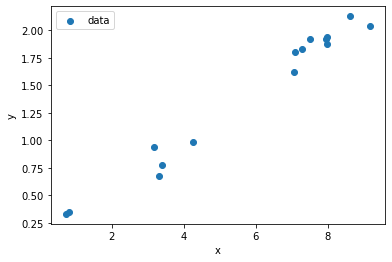

In [4]:
# Generate and plot data
random.seed(1)
n = 15
def sample_data(num_points):
    x = rand(num_points)*10
    y = .2 + .2*x + .1*np.sin(x) + .1*randn(num_points) - .01*((x-5)/6)**4
    return x,y

x,y = sample_data(n)


def plotdata(x=x,y=y, margin=.05):
    plt.scatter(x,y, label="data")
    plt.legend(loc="upper left")
    plt.xlabel("x") 
    plt.ylabel("y")     
    range_y = np.max(y) - np.min(y)
    range_x = np.max(x) - np.min(x)
    plt.ylim([np.min(y)-margin*range_y,np.max(y)+margin*range_y])
    plt.xlim([np.min(x)-margin*range_x,np.max(x)+margin*range_x])
    
plotdata()
plt.show()

# Approximating with the mean

In [5]:
# the mean solves a very simple least squares problem:
X = np.ones((n,1))
w = np.linalg.lstsq(X, y)[0]

<ipython-input-5-6dd8b0414b56>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


In [6]:
# check the solution to our least squares problem is the mean
np.abs(np.mean(y) - w[0])

4.440892098500626e-16

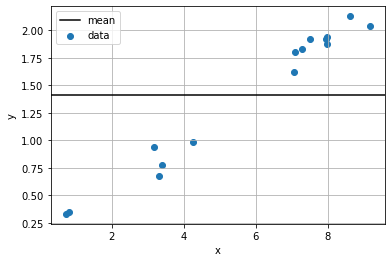

In [7]:
# plot the fit
plotdata()
plotline(0, w[0], label="mean")
plt.show()

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

# Approximating with a line

In [8]:
X = np.column_stack([x, np.ones(n)])
print(X)

[[9.17659925 1.        ]
 [4.24967857 1.        ]
 [7.06935241 1.        ]
 [7.07887648 1.        ]
 [3.38401498 1.        ]
 [7.95169275 1.        ]
 [8.62593866 1.        ]
 [7.9695171  1.        ]
 [7.50184653 1.        ]
 [3.18196031 1.        ]
 [7.97680959 1.        ]
 [7.27168596 1.        ]
 [3.31760262 1.        ]
 [0.80455804 1.        ]
 [0.72390102 1.        ]]


# How to fit a least squares model
There are many ways to fit a least squares model in python!
1. QR decomposition + `scipy.linalg.solve`
2. `numpy.linalg.lstsq`
3. `statsmodels.OLS`
4. `sklearn.LinearRegression()`

In [9]:
# method 0: scipy
from scipy.linalg import qr, solve
Q,R = qr(X, mode='economic')
w = solve(R, Q.T @ y)
w

array([0.22555996, 0.11083929])

In [10]:
# method 1: numpy
w = np.linalg.lstsq(X, y)[0]
w

<ipython-input-10-4844ed0cbb71>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


array([0.22555996, 0.11083929])

In [11]:
# method 2: statsmodels
model = sm.OLS(y, X).fit()
w = model.params
w

array([0.22555996, 0.11083929])

In [12]:
# method 3: sklearn
model = LinearRegression().fit(x[None,].T,y)
w = np.array([model.coef_[0], model.intercept_])
w

array([0.22555996, 0.11083929])

Below we have to do some work to reconcile the default types of NumPy and PyTorch. Note that NumPy will default to float64 on a 64-bit system. PyTorch models default to float32 as GPUs can do up to 64x the operations per clock cycle than when using float64. [CUDA operations per cycle comparison](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#arithmetic-instructions)

In [13]:
# method 4: PyTorch via SGD

def TorchLinRegModel(n : int = 2):
    """Create a simple linear regression model in PyTorch. Note that
    we're manually including the bias in this demo."""
    return nn.Linear(in_features=n, out_features=1, bias=False)

model = TorchLinRegModel()
model.zero_grad()
optimizer = optim.SGD(model.parameters(), lr=5e-6)
loss_function = nn.MSELoss()

n_epochs = 5000
batch_size = 8

for epoch in range(n_epochs):
    # let's do a random order after converting to a torch array
    shuffled_indices = torch.randperm(x.shape[0])
    for batch in range(0, x.shape[0], batch_size):
        sample_idxs = shuffled_indices[batch:batch+batch_size]
        
        # PyTorch accumulates gradients everytime we calculate
        # them. So, we need to clear gradient updates that existed 
        # before we updated our model.
        optimizer.zero_grad()
        
        # Read minibatch data. PyTorch models default to float32  
        # so we need to convert from double precision to float32
        tensor = torch.from_numpy(X[sample_idxs, :]).float()
        output = model(tensor)
        
        batch_labels = torch.from_numpy(y[sample_idxs]).float()
        batch_labels = batch_labels.view(-1, 1)
        
        # loss.backward() calculates the gradient of the loss with
        # respect to the weights
        loss = loss_function(output, batch_labels)
        loss.backward()
        
        # optimizer.step() moves in the direction of the gradient
        # based on the learning rate (i.e. step size)
        optimizer.step()
        
        
w = list(model.parameters())[0][0].detach().numpy()
w

array([0.19833243, 0.2257532 ], dtype=float32)

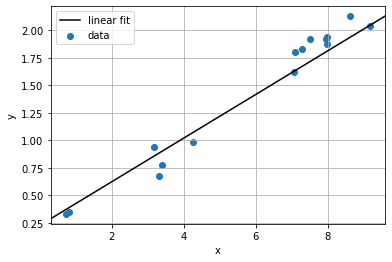

In [14]:
# plot the fit
plotdata()
plotline(w[0], w[1], label="linear fit")

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

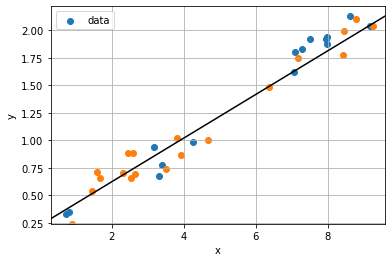

In [15]:
# plot fit on out of sample data
plotdata()
plotline(w[0], w[1])

xtest,ytest = sample_data(20)
plt.scatter(xtest,ytest,label="test")

# Approximating with a polynomial

In [16]:
# first, construct a Vandermonde matrix
n = 15
max_order = 10
X = np.zeros((n, max_order+1))

# method 1: use the default Vandermonde function from numpy
X = np.vander(x, max_order+1, increasing = True)
# method 2: use a for loop
# for k in range(max_order+1):
#     X[:,k] = x**(k)
    
# create a pandas dataframe with data = Vandermonde
col_list = ["order"+str(i) for i in range(max_order+1)]   
df1 = pd.DataFrame(data = X, columns=col_list)
df1

,order0,order1,order2,order3,order4,order5,order6,order7,order8,order9,order10
0,1.0,9.176599,84.209974,772.761183,7091.319698,65074.199043,597159.846359,5.479897e+06,5.028682e+07,4.614619e+08,4.234651e+09
1,1.0,4.249679,18.059768,76.748209,326.155217,1386.054836,5890.287529,2.503183e+04,1.063772e+05,4.520690e+05,1.921148e+06
2,1.0,7.069352,49.975744,353.296143,2497.574940,17656.237422,124818.164588,8.823836e+05,6.237881e+06,4.409778e+07,3.117427e+08
3,1.0,7.078876,50.110492,354.725985,2511.061434,17775.493728,125830.524514,8.907387e+05,6.305430e+06,4.463536e+07,3.159682e+08
4,1.0,3.384015,11.451557,38.752242,131.138166,443.773518,1501.736232,5.081898e+03,1.719722e+04,5.819565e+04,1.969349e+05
5,1.0,7.951693,63.229418,502.780902,3997.959250,31790.543587,252788.634980,2.010098e+06,1.598368e+07,1.270973e+08,1.010639e+09
6,1.0,8.625939,74.406818,641.828646,5536.374532,47756.427120,411944.011000,3.553404e+06,3.065144e+07,2.643975e+08,2.280676e+09
7,1.0,7.969517,63.513203,506.169557,4033.926938,32148.449728,256207.619963,2.041851e+06,1.627257e+07,1.296845e+08,1.033523e+09
8,1.0,7.501847,56.277701,422.186678,3167.179664,23759.695759,178241.591090,1.337141e+06,1.003103e+07,7.525123e+07,5.645231e+08
9,1.0,3.181960,10.124871,32.216939,102.513021,326.192364,1037.931157,3.302656e+03,1.050892e+04,3.343896e+04,1.064015e+05


In [17]:
# helper function: create a Vandermonde matrix in pandas.dataframe
def Vandermonde_df(x, order = max_order):
    X = np.vander(x, order+1, increasing = True)
    col_list = ["order"+str(i) for i in range(order+1)]   
    df = pd.DataFrame(data = X, columns=col_list)
    return df

In [18]:
# solve least squares problem
model = sm.OLS(y, df1).fit()
w = model.params
print(w)

order0      389.912799
order1    -1587.733916
order2     2501.575926
order3    -2007.265101
order4      940.650691
order5     -276.117877
order6       52.346142
order7       -6.410020
order8        0.489882
order9       -0.021255
order10       0.000400
dtype: float64


In [19]:
# output the prediction given our polynomial fit
df1.dot(w)

0     2.037942
1     0.988485
2     1.688069
3     1.702008
4     0.736566
5     1.906166
6     2.125348
7     1.915422
8     1.890580
9     0.925542
10    1.919427
11    1.875053
12    0.732879
13    0.350094
14    0.330142
dtype: float64

In [20]:
#computes our polynomial fit evaluated at x
def p(x, order = max_order, w = w):
    df = Vandermonde_df(x, order)
    y = df.dot(w)
    return np.array(y)

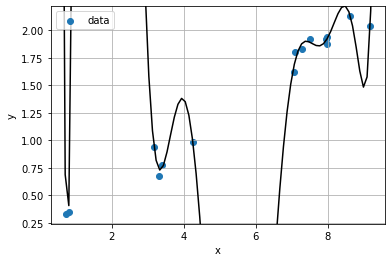

In [21]:
# plot fit
plotdata()
plotfunc(p, xmin=0, xmax=10)

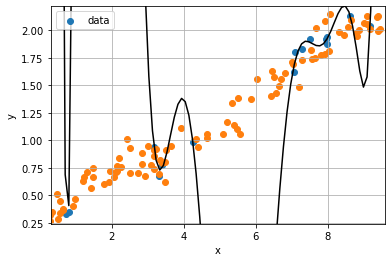

In [22]:
# plot fit on out of sample data
plotdata()
plotfunc(p, xmin=0, xmax=10)

xtest,ytest = sample_data(100)
plt.scatter(xtest,ytest,label="test")

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

# Choosing the best model order

In [23]:
max_model_order = 10
rmse = np.zeros(max_model_order+1)       # array to store root mean square model errors
rmse_train = np.zeros(max_model_order+1) # array to store root mean square model errors on training set
xtest,ytest = sample_data(50)   # generate test set

for model_order in range(max_model_order+1):
    # form Vandermonde matrix
    df = Vandermonde_df(x, model_order)
    
    # solve least squares problem
    model = sm.OLS(y, df).fit()
    w = model.params
    ytrain = df.dot(w)
    
    # compute training error 
    rmse_train[model_order] = np.mean(np.abs(y - np.array(ytrain))) # sqrt(mean((y - X*w).^2))
    
    # compute test error
    ptest = p(xtest, order=model_order, w=w)
    rmse[model_order] = np.mean(np.abs(ytest - np.array(ptest))) # sqrt(mean((ytest - ptest).^2))
rmse

array([ 0.51014175,  0.16070909,  0.15469955,  0.15466363,  0.10740045,
        0.10237344,  0.14001532,  0.19382173,  0.5749932 ,  2.57928713,
       17.06602024])

Text(0, 0.5, 'rmse')

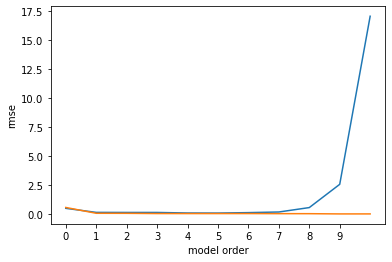

In [24]:
plt.plot(range(max_model_order+1),rmse, label="test error")
plt.plot(range(max_model_order+1),rmse_train, label="train error")
plt.xticks(np.arange(0,10,step=1.0))
plt.xlabel("model order")
plt.ylabel("rmse")

# Polynomial models for classification

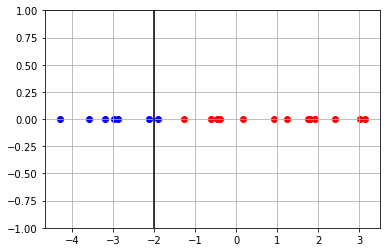

In [25]:
random.seed(0)
n = 20
xs = 10*(rand(n) - .5)
ys = (xs)**2
pos = (xs - 1)**2 >= 7
zn=np.zeros(n)
pt = plt.scatter(xs[pos],zn[pos],color="blue", label="positive")
plt.scatter(xs[~pos],zn[~pos],color="red", label="negative")
plt.plot([-2,-2], [-1,1], color="black", label="classification boundary")#, ticks=:none, border=:none, legend=false)
plt.ylim([-1,1])
plt.grid()
# savefig("poly-class-1d.pdf")
pt

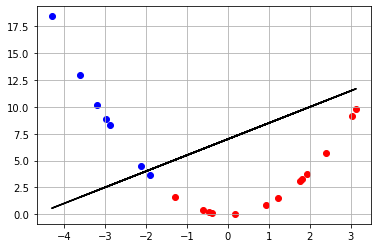

In [26]:
pt = plt.scatter(xs[pos],ys[pos],color="blue", label="positive")
plt.scatter(xs[~pos],ys[~pos],color="red", label="negative")
plt.plot(xs, 1.5*xs + 7, color="black", label="classification boundary")
plt.grid()
# savefig("poly-class-2d.pdf")
pt

In [27]:
# Example 1: multivariate polynomial classification 
n = 1000
scale = 50
x1 = scale*rand(n) - scale/2
x2 = scale*rand(n) - scale/2
f = lambda x1, x2: -30 - 9*x1 + 2*x2 + x1**2 - 0*x1*x2 + x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

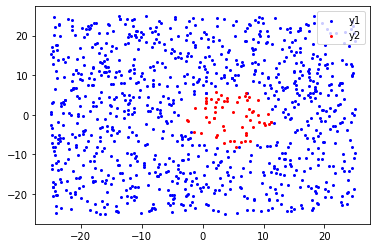

In [28]:
plt.scatter(x1[pos], x2[pos], color="blue", s=4, label='y1')
plt.scatter(x1[neg], x2[neg], color="red", s=4, label='y2')
plt.legend(loc="upper right")

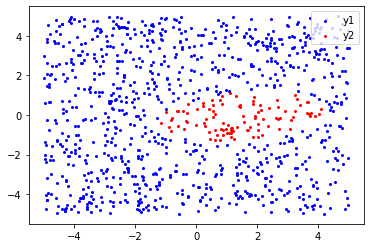

In [29]:
# Example 2: multivariate polynomial classification 
n = 1000
scale = 10
x1 = scale*rand(n) - scale/2
x2 = scale*rand(n) - scale/2
f = lambda x1, x2: -5 - 3*x1 + 2*x2 + x1**2 - x1*x2 + 5*x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

plt.scatter(x1[pos], x2[pos], s=4, color="blue", label="y1")
plt.scatter(x1[neg], x2[neg], s=4, color="red", label="y2")
plt.legend(loc="upper right")

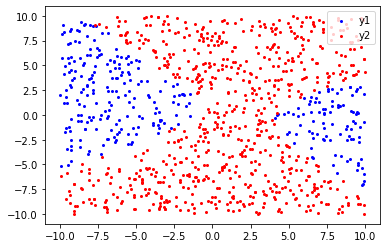

In [30]:
# Example 3: multivariate polynomial classification 
n = 1000
scale = 20
x1 = scale*rand(n) - scale/2
x2 = scale*rand(n) - scale/2
f = lambda x1, x2: -5 - 3*x1 + 2*x2 + x1**2 - x1*x2 - 2*x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

plt.scatter(x1[pos], x2[pos], color="blue", s=4, label="y1")
plt.scatter(x1[neg], x2[neg], color="red", s=4, label="y2")
plt.legend(loc="upper right")